
=== DERIVED FUNDAMENTAL SCALES (WILL RG) ===
Input T_CMB: 2.7255 K, Alpha: 0.0072973525693
Derived H0:  68.1467 km/s/Mpc
a_Mach (Unmodified): 1.0537e-10 m/s^2 (Coeff: 1/2pi)
Omega_pot:           0.6667
a_Kappa (WILL):      7.0250e-11 m/s^2 (Coeff: 1/3pi)
a_Verlinde (Emerg):  1.1035e-10 m/s^2 (Coeff: 1/6)

=== BASELINE PARAMETERS ===
LCDM Baseline H0: 67.4 km/s/Mpc (Planck 2018)
Loaded 3391 data points across 175 galaxies.

Computing models...
Computing LCDM Abundance Matching (Planck 2018 parameters)...

MODEL           | MedAE    | Bias     | F10   
------------------------------------------------------------
Newton          | 38.46     | +36.91    | 0.08
LCDM (AM)       | 13.32     | -6.83    | 0.36
MOND (Std)      | 10.43     | -4.37    | 0.48
Verlinde        | 12.27     | -8.52    | 0.33
WILL RG         | 11.18     | -2.26    | 0.47

GAS-DOMINATED SUBSET (GasFrac > 0.5)
Galaxies: 32
------------------------------------------------------------
Newton          | 31.14     | +31.14  

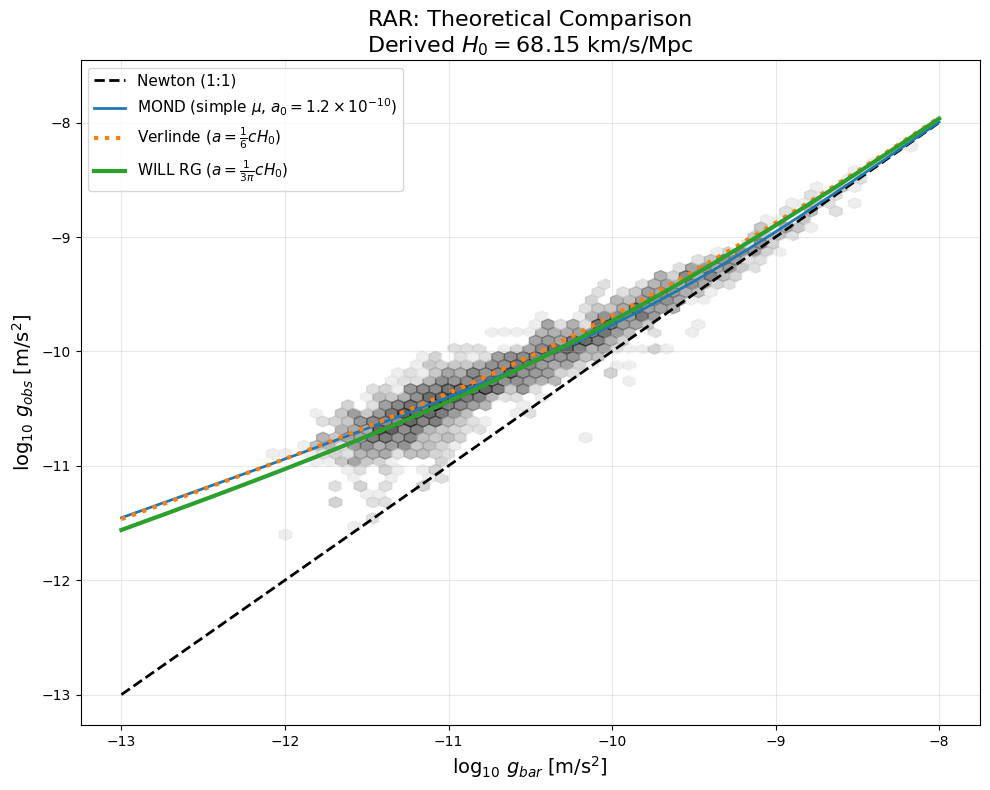

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize

# =========================
# DATA SOURCE
# =========================
PATH_TABLE2 = "https://raw.githubusercontent.com/AntonRize/WILL/refs/heads/main/SPARC%20DATA/table2.dat"

# =========================
# GLOBAL CONFIG (FIXED)
# =========================
# SPARC Standard Mass-to-Light Ratios (Lelli et al. 2016) — FIXED
UPS_DISK = 0.5
UPS_BUL  = 0.7

# Metrics — FIXED
TOL_KMS = 10.0
GAS_DOM_THRESH = 0.50

# =========================
# PHYSICAL CONSTANTS (SI) — FIXED
# =========================
C_SI = 2.99792458e8         # m/s
G_SI = 6.67430e-11          # m^3 kg^-1 s^-2
SIGMA_SB = 5.670374419e-8   # W m^-2 K^-4

# WILL RG fundamental inputs — FIXED
T0_CMB = 2.7255             # K (Fixsen 2009)
ALPHA = 7.2973525693e-3     # Fine structure constant

# PLANCK 2018 CONSTANTS (Exclusively for LCDM Baseline)
H0_PLANCK_KMS_MPC = 67.4    # Planck 2018 (VI)
# Note: h = 0.674 used in concentration relation matches this.

# Unit conversions — FIXED
KPC_TO_M = 3.085677581e19
MPC_TO_M = 3.085677581e22
MSUN_TO_KG = 1.98847e30

# Derived Planck H0 in SI (for NFW virial radius calc)
H0_PLANCK_SI = H0_PLANCK_KMS_MPC * 1000.0 / MPC_TO_M


# =========================
# 1) CORE DERIVATION (WILL RG) — FIXED
# =========================
def derive_cosmological_scales():
    """
    Derives H0 and acceleration scales purely from T_CMB and Alpha.
    No external H0 is used for WILL/Verlinde models.
    """
    # Radiation density (mass density) from Stefan–Boltzmann:
    # u = a T^4, rho = u/c^2, and a = 4 sigma / c
    # => rho = 4 sigma T^4 / c^3
    rho_gamma = (4.0 * SIGMA_SB * (T0_CMB**4)) / (C_SI**3)

    # Your Step 2 (fixed): rho_max = rho_gamma / (3 alpha^2)
    rho_max = rho_gamma / (3.0 * ALPHA**2)

    # H0 from rho_max
    H0_si = np.sqrt(8.0 * np.pi * G_SI * rho_max)

    # Acceleration scales
    a_mach = (C_SI * H0_si) / (2.0 * np.pi)  # Mach's Acceleration 1/(2π)

    # Introduce Omega_pot and a_kappa
    omega_pot = 2.0 / 3.0  # Potential weight of the total resource
    a_kappa = omega_pot * a_mach  # potential global acceleration (C_SI * H0_si) / (3.0 * np.pi)

    a_verl = (C_SI * H0_si) / 6.0            # Verlinde coefficient 1/6

    H0_kms_mpc = H0_si * (MPC_TO_M / 1000.0)

    return {
        "rho_gamma": rho_gamma,
        "rho_max": rho_max,
        "H0_si": H0_si,
        "H0_kms_mpc": H0_kms_mpc,
        "a_mach": a_mach, # Keeping a_mach in return for clarity
        "a_verlinde": a_verl,
        "omega_pot": omega_pot,
        "a_kappa": a_kappa
    }


# =========================
# 2) DATA LOADING & PREP
# =========================
def load_sparc_data():
    print("Downloading SPARC catalog table2.dat ...")
    cols = [(0, 11), (19, 25), (26, 32), (33, 38), (39, 45), (46, 52), (53, 59)]
    names = ['Name', 'Rad', 'Vobs', 'e_Vobs', 'Vgas', 'Vdisk', 'Vbul']
    df = pd.read_fwf(PATH_TABLE2, colspecs=cols, header=None, names=names, comment='#')

    # numeric coercion
    for c in names[1:]:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # basic cleaning (fixed)
    df = df.dropna(subset=['Vobs', 'Rad'])
    df = df[(df['Rad'] > 0) & (df['Vobs'] > 0)]
    df['Vbul'] = df['Vbul'].fillna(0.0)

    print(f"Loaded {len(df)} data points across {df['Name'].nunique()} galaxies.")
    return df


def get_baryonic_velocity(df, ups_disk=UPS_DISK, ups_bul=UPS_BUL):
    # Enforce non-negativity (fixed protocol)
    Vgas  = np.maximum(df['Vgas'].values,  0.0)
    Vdisk = np.maximum(df['Vdisk'].values, 0.0)
    Vbul  = np.maximum(df['Vbul'].values,  0.0)
    Vb2 = Vgas**2 + ups_disk*(Vdisk**2) + ups_bul*(Vbul**2)
    return np.sqrt(np.maximum(Vb2, 0.0))


def add_gas_fraction(df, ups_disk=UPS_DISK, ups_bul=UPS_BUL):
    Vgas  = np.maximum(df['Vgas'].values,  0.0)
    Vdisk = np.maximum(df['Vdisk'].values, 0.0)
    Vbul  = np.maximum(df['Vbul'].values,  0.0)
    denom = (Vgas**2) + ups_disk*(Vdisk**2) + ups_bul*(Vbul**2)
    df['GasFrac'] = np.where(denom > 0, (Vgas**2)/denom, 0.0)
    return df


# =========================
# 3) MODELS (FIXED)
# =========================
def model_mond(Vb_kms, Rad_kpc, a0=1.2e-10):
    r_m   = Rad_kpc * KPC_TO_M
    Vb_ms = Vb_kms * 1000.0
    gN    = (Vb_ms**2) / r_m
    g     = (gN + np.sqrt(gN**2 + 4.0*gN*a0)) / 2.0
    V_ms  = np.sqrt(g * r_m)
    return V_ms / 1000.0


def model_interference(Vb_kms, Rad_kpc, a_scale):
    """
    WILL/Verlinde structural form:
    V^2 = Vb^2 + sqrt(Vb^2 * a * r)
    """
    r_m   = Rad_kpc * KPC_TO_M
    Vb_ms = Vb_kms * 1000.0
    coupling = np.sqrt((Vb_ms**2) * a_scale * r_m)
    V_ms = np.sqrt((Vb_ms**2) + coupling)
    return V_ms / 1000.0


# =========================
# 4) LCDM (Abundance Matching, NO FITTING)
# =========================
def _f_nfw(u):
    return np.log(1.0 + u) - u/(1.0 + u)


def _estimate_stellar_mass_from_components(df_gal, ups_disk=UPS_DISK, ups_bul=UPS_BUL):
    """
    Deterministic proxy using SPARC stellar components in table2:
    M(<r) = V^2 r / G, using the *outermost* radius point (stable).
    This is not a fit: it is a direct inversion of the provided decomposed V-components.
    """
    g = df_gal.sort_values('Rad')
    r_m = g['Rad'].values * KPC_TO_M

    Vd = np.maximum(g['Vdisk'].values, 0.0) * 1000.0
    Vb = np.maximum(g['Vbul'].values,  0.0) * 1000.0

    # enclosed mass profiles for Υ=1
    Mdisk_enc = (Vd**2) * r_m / G_SI
    Mbul_enc  = (Vb**2) * r_m / G_SI

    # take outermost value (last point)
    Mdisk = Mdisk_enc[-1] if len(Mdisk_enc) else 0.0
    Mbul  = Mbul_enc[-1]  if len(Mbul_enc)  else 0.0

    Mstar_kg = ups_disk*Mdisk + ups_bul*Mbul
    Mstar_msun = max(Mstar_kg / MSUN_TO_KG, 1e6)  # floor prevents log issues (fixed rule)
    return Mstar_msun


def _moster_invert_Mstar_to_M200(Mstar_msun):
    """
    Moster et al. (2013), z=0 parameters — FIXED.
    Solve logM200 in [9,15] deterministically (no fitting to SPARC).
    """
    N     = 0.0351
    M1    = 10**11.59
    beta  = 1.376
    gamma = 0.608

    def eq(logM200):
        M200 = 10**logM200
        ratio = 2.0*N / ((M200/M1)**(-beta) + (M200/M1)**gamma)
        Mstar_pred = M200 * ratio
        return np.log10(Mstar_pred) - np.log10(Mstar_msun)

    try:
        sol = optimize.root_scalar(eq, bracket=[9.0, 15.0], method='brentq')
        return 10**sol.root
    except Exception:
        return 10**11.0  # deterministic fallback (still fixed)


def _dutton_maccio_c200(M200_msun):
    """
    Dutton & Macciò (2014) Planck-like relation — FIXED.
    """
    h = 0.674  # Consistent with Planck 2018
    return 10**(0.905 - 0.101*np.log10(M200_msun*h/1e12))


def _nfw_vhalo_kms(r_m, M200_msun, c200, H0_si):
    """
    Correct NFW circular velocity:
    V^2 = V200^2 * [ f(cy) / ( y * f(c) ) ],  y=r/R200.
    """
    M200_kg = M200_msun * MSUN_TO_KG

    # R200 depends on H0. Here H0_si must be the Planck value for LCDM.
    R200_m = (G_SI * M200_kg / (100.0 * H0_si**2))**(1.0/3.0)
    V200_2 = G_SI * M200_kg / R200_m

    y = np.where(r_m > 0, r_m / R200_m, np.nan)      # r/R200
    x = c200 * y                                     # c r/R200

    fc = _f_nfw(c200)
    fx = _f_nfw(x)

    V2 = V200_2 * (fx / (y * fc))
    V2 = np.nan_to_num(V2, nan=0.0, posinf=0.0, neginf=0.0)

    return np.sqrt(V2) / 1000.0


def model_lcdm_abundance_matching(df_gal, ups_disk=UPS_DISK, ups_bul=UPS_BUL, H0_si=None):
    """
    NO per-galaxy free parameters:
      - Mstar proxy -> M200 via fixed Moster(2013)
      - c200 via fixed Dutton+Macciò(2014)
      - NFW profile fixed
    """
    if H0_si is None:
        raise ValueError("H0_si must be provided.")

    Mstar_msun = _estimate_stellar_mass_from_components(df_gal, ups_disk, ups_bul)
    M200_msun  = _moster_invert_Mstar_to_M200(Mstar_msun)
    c200       = _dutton_maccio_c200(M200_msun)

    g = df_gal.sort_values('Rad')
    r_m = g['Rad'].values * KPC_TO_M

    Vb_kms = get_baryonic_velocity(g, ups_disk, ups_bul)

    # Calculate Halo velocity using the provided H0 (Planck for LCDM)
    Vh_kms = _nfw_vhalo_kms(r_m, M200_msun, c200, H0_si)

    Vtot = np.sqrt(Vb_kms**2 + Vh_kms**2)

    # return aligned to original index order
    out = pd.Series(Vtot, index=g.index).reindex(df_gal.index)
    return out.values


# =========================
# 5) METRICS (FIXED)
# =========================
def calc_metrics(df_full, V_pred_col):
    rows = []
    for name, g in df_full.groupby('Name'):
        resid = g['Vobs'] - g[V_pred_col]
        rows.append({
            'Name': name,
            'MedAE': np.median(np.abs(resid)),
            'Bias':  np.median(resid),
            'F10':   np.mean(np.abs(resid) < TOL_KMS)
        })
    t = pd.DataFrame(rows)
    return {
        'MedAE': t['MedAE'].median(),
        'Bias':  t['Bias'].median(),
        'F10':   t['F10'].median()
    }


# =========================
# 6) RAR PLOT (CONSISTENT FORMS)
# =========================
def plot_rar(df, consts, fname="sparc_rar_comparison.png"):
    r_m = df['Rad'].values * KPC_TO_M
    v_obs_ms = df['Vobs'].values * 1000.0
    v_bar_ms = df['Vb'].values   * 1000.0

    g_obs = (v_obs_ms**2) / r_m
    g_bar = (v_bar_ms**2) / r_m

    mask = (g_obs > 1e-13) & (g_bar > 1e-13)
    g_obs = g_obs[mask]
    g_bar = g_bar[mask]

    plt.figure(figsize=(10, 8))
    hb = plt.hexbin(np.log10(g_bar), np.log10(g_obs), gridsize=55,
                    cmap='Greys', mincnt=1, bins='log', alpha=0.65)

    gx = np.logspace(-13, -8, 300)

    # Newton
    plt.plot(np.log10(gx), np.log10(gx), 'k--', lw=2, label='Newton (1:1)')

    # MOND (simple mu) — fixed a0
    a0_mond = 1.2e-10
    gy_mond = (gx + np.sqrt(gx**2 + 4.0*gx*a0_mond)) / 2.0
    plt.plot(np.log10(gx), np.log10(gy_mond), lw=2, label=r"MOND (simple $\mu$, $a_0=1.2\times10^{-10}$)")

    # Verlinde interference form (as used in velocity model)
    av = consts['a_verlinde']
    gy_ver = gx + np.sqrt(gx * av)
    plt.plot(np.log10(gx), np.log10(gy_ver), lw=3, linestyle=':',
             label=r"Verlinde ($a=\frac{1}{6}cH_0$)")

    # WILL interference form (as used in velocity model)
    am = consts['a_kappa']
    gy_will = gx + np.sqrt(gx * am)
    plt.plot(np.log10(gx), np.log10(gy_will), lw=3,
             label=r"WILL RG ($a=\frac{1}{3\pi}cH_0$)")

    plt.xlabel(r'$\log_{10}\, g_{bar}\;[\mathrm{m/s^2}]$', fontsize=14)
    plt.ylabel(r'$\log_{10}\, g_{obs}\;[\mathrm{m/s^2}]$', fontsize=14)
    plt.title(f"RAR: Theoretical Comparison\nDerived $H_0 = {consts['H0_kms_mpc']:.2f}$ km/s/Mpc", fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.savefig(fname, dpi=300)
    print(f"Graph saved: {fname}")


# =========================
# MAIN EXECUTION
# =========================
def run_analysis():
    consts = derive_cosmological_scales()
    print("\n=== DERIVED FUNDAMENTAL SCALES (WILL RG) ===")
    print(f"Input T_CMB: {T0_CMB} K, Alpha: {ALPHA}")
    print(f"Derived H0:  {consts['H0_kms_mpc']:.4f} km/s/Mpc")
    print(f"a_Mach (Unmodified): {consts['a_mach']:.4e} m/s^2 (Coeff: 1/2pi)") # Clarify a_mach
    print(f"Omega_pot:           {consts['omega_pot']:.4f}")
    print(f"a_Kappa (WILL):      {consts['a_kappa']:.4e} m/s^2 (Coeff: 1/3pi)") # Use a_kappa
    print(f"a_Verlinde (Emerg):  {consts['a_verlinde']:.4e} m/s^2 (Coeff: 1/6)")

    print("\n=== BASELINE PARAMETERS ===")
    print(f"LCDM Baseline H0: {H0_PLANCK_KMS_MPC} km/s/Mpc (Planck 2018)")

    df = load_sparc_data()
    df['Vb'] = get_baryonic_velocity(df)
    df = add_gas_fraction(df)

    print("\nComputing models...")

    # Newton
    df['V_Newton'] = df['Vb']

    # MOND
    df['V_MOND'] = model_mond(df['Vb'].values, df['Rad'].values)

    # Verlinde (Uses Derived H0)
    df['V_Verlinde'] = model_interference(df['Vb'].values, df['Rad'].values, consts['a_verlinde'])

    # WILL (Uses Derived H0)
    df['V_WILL'] = model_interference(df['Vb'].values, df['Rad'].values, consts['a_kappa']) # Use a_kappa

    # LCDM (AM) — deterministic per galaxy
    # CRITICAL UPDATE: Uses Planck 2018 H0 for R200 scaling, NOT the derived H0.
    print("Computing LCDM Abundance Matching (Planck 2018 parameters)...")
    V_LCDM = np.empty(len(df), dtype=float)
    for name, g in df.groupby('Name'):
        # Pass PLANCK H0 here
        V_LCDM[g.index] = model_lcdm_abundance_matching(g, H0_si=H0_PLANCK_SI)
    df['V_LCDM'] = V_LCDM

    models = {
        'Newton': 'V_Newton',
        'LCDM (AM)': 'V_LCDM',
        'MOND (Std)': 'V_MOND',
        'Verlinde': 'V_Verlinde',
        'WILL RG': 'V_WILL'
    }

    print("\n" + "="*60)
    print(f"{'MODEL':<15} | {'MedAE':<8} | {'Bias':<8} | {'F10':<6}")
    print("-"*60)
    for label, col in models.items():
        m = calc_metrics(df, col)
        print(f"{label:<15} | {m['MedAE']:.2f}     | {m['Bias']:+.2f}    | {m['F10']:.2f}")
    print("="*60)

    # Gas-dominated subset
    gas_gal = df.groupby('Name')['GasFrac'].median()
    gas_names = gas_gal[gas_gal >= GAS_DOM_THRESH].index
    df_gas = df[df['Name'].isin(gas_names)]

    print(f"\nGAS-DOMINATED SUBSET (GasFrac > {GAS_DOM_THRESH})")
    print(f"Galaxies: {len(gas_names)}")
    print("-"*60)
    for label, col in models.items():
        m = calc_metrics(df_gas, col)
        print(f"{label:<15} | {m['MedAE']:.2f}     | {m['Bias']:+.2f}    | {m['F10']:.2f}")

    # Plot RAR
    plot_rar(df, consts)

    # Save
    df.to_csv("sparc_results_complete.csv", index=False)
    print("\nFull results saved to sparc_results_complete.csv")


if __name__ == "__main__":
    run_analysis()